C:\Users\sreep\AppData\Local\Temp\ipykernel_42644\2658451397.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=device)


✅ Loaded EfficientNet-B3 model from: C:\Users\sreep\OneDrive\Desktop\Food based\.venv\best_food_classifier_b3.pth

🍽️ Predicted Food Type: chicken_curry


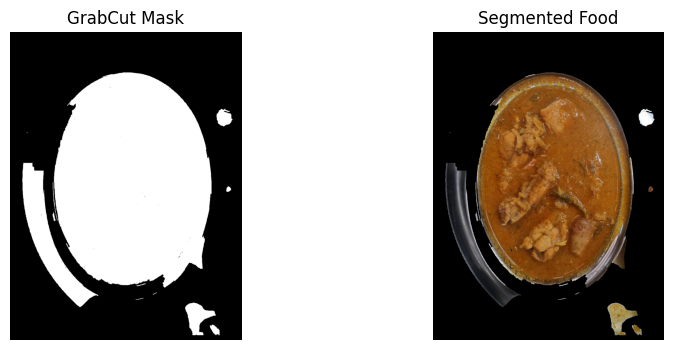

🧩 Foreground pixels (food area): 531128

🔍 Searching USDA for: chicken curry
✅ Found: Chicken curry
🔥 Energy: 107.00 kcal / 100g

📊 CALORIE ESTIMATION REPORT
🍽️ Predicted Food: chicken_curry
🧩 Food pixel count: 531128
📏 Estimated area: 331.96 cm²
⚖️ Estimated weight (1 cm² ≈ 1g): 331.96 g
🔥 Calories per 100g (USDA): 107.00
🍰 Estimated total calories: 355.19 kcal

✅ Masked image saved as: segmented_chicken_curry_image4.png


In [1]:
# ------------------------------------------------------------
# 🍞 FOOD CLASSIFICATION + PIXEL-BASED CALORIE ESTIMATION
# Using EfficientNet-B3 + GrabCut + USDA API
# ------------------------------------------------------------

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# ============================================================
# CONFIGURATION
# ============================================================
#IMAGE_PATH = r"./images.jpeg"
# IMAGE_PATH = r"C:\Users\sreep\OneDrive\Desktop\Food based\.venv\images\steak\9555.jpg"
#IMAGE_PATH = r"C:\Users\sreep\OneDrive\Desktop\Food based\.venv\images\omelette\7566.jpg"
IMAGE_PATH = r"C:\Users\sreep\OneDrive\Desktop\Food based\src\image4.jpg"
# IMAGE_PATH = r"./image3.jpg"
MODEL_PATH = r"C:\Users\sreep\OneDrive\Desktop\Food based\.venv\best_food_classifier_b3.pth"
CLASS_FILE = r"C:\Users\sreep\OneDrive\Desktop\Food based\data\food-101\meta\classes.txt"
API_KEY = "3MAZSbznBwb08neomhHMnSDTqZLBdiJzImKO9d6e"  # 🔑 Replace with your USDA key
PLATE_DIAMETER_CM = 24.0  # assumed plate diameter (cm)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# STEP 0 — LOAD TRAINED MODEL
# ============================================================

# Load class names
with open(CLASS_FILE, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
num_classes = len(class_names)

# Create EfficientNet-B3 structure
def create_model(num_classes):
    model = models.efficientnet_b3(weights=None)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# Load weights
model = create_model(num_classes).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
try:
    model.load_state_dict(state_dict)
    print(f"✅ Loaded EfficientNet-B3 model from: {MODEL_PATH}")
except RuntimeError:
    print("⚠️ Classifier mismatch — loading backbone only...")
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier.1")}
    model.load_state_dict(filtered_state_dict, strict=False)
    print("✅ Backbone loaded successfully.")

model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# ============================================================
# STEP 1 — CLASSIFY THE FOOD IMAGE
# ============================================================
img_pil = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = transform(img_pil).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_label = class_names[predicted_idx.item()]

print(f"\n🍽️ Predicted Food Type: {predicted_label}")

# ============================================================
# STEP 2 — SEGMENT IMAGE USING GRABCUT
# ============================================================
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
rect = (15, 15, w - 35, h - 35)
mask = np.zeros((h, w), np.uint8)
bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)

cv2.grabCut(img, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
segmented = img_rgb * mask2[:, :, np.newaxis]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("GrabCut Mask")
plt.imshow(mask2, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmented Food")
plt.imshow(segmented)
plt.axis("off")
plt.show()

# ============================================================
# STEP 3 — CALCULATE FOOD PIXEL AREA
# ============================================================
food_pixels = np.count_nonzero(mask2)
print(f"🧩 Foreground pixels (food area): {food_pixels}")

# ============================================================
# STEP 4 — FETCH CALORIE DATA FROM USDA
# ============================================================
def search_usda_food(food_name, api_key):
    """Search USDA database for a food and return the first entry."""
    url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {"api_key": api_key, "query": food_name, "pageSize": 1}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    if "foods" not in data or not data["foods"]:
        raise ValueError(f"No USDA entry found for '{food_name}'.")
    return data["foods"][0]

def get_kcal_per_100g(food_entry):
    """Extract kcal per 100g from USDA entry."""
    for n in food_entry.get("foodNutrients", []):
        if "energy" in n.get("nutrientName", "").lower() and "kcal" in n.get("unitName", "").lower():
            return n["value"]
    raise ValueError("No energy (kcal) info found in USDA entry.")

# Query USDA
query_name = predicted_label.replace("_", " ")
print(f"\n🔍 Searching USDA for: {query_name}")

try:
    entry = search_usda_food(query_name, API_KEY)
except ValueError:
    alt_name = predicted_label.split("_")[0]
    print(f"⚠️ Retrying with fallback term: '{alt_name}'")
    entry = search_usda_food(alt_name, API_KEY)

desc = entry.get("description", "No description")
kcal_per_100g = get_kcal_per_100g(entry)
cal_per_g = kcal_per_100g / 100  # kcal per gram

print(f"✅ Found: {desc}")
print(f"🔥 Energy: {kcal_per_100g:.2f} kcal / 100g")

# ============================================================
# STEP 5 — CALORIE ESTIMATION (AREA + SCALE ONLY)
# ============================================================

# convert pixel area to real area using plate diameter
plate_diameter_px = img.shape[1]  # image width
px_per_cm = plate_diameter_px / PLATE_DIAMETER_CM
area_per_pixel = (1 / px_per_cm) ** 2
food_area_cm2 = food_pixels * area_per_pixel

# Assume 1 cm² of food ≈ 1 g (flat proportional scaling)
food_weight_g = food_area_cm2

# total calories
estimated_calories = food_weight_g * cal_per_g

print("\n========================")
print("📊 CALORIE ESTIMATION REPORT")
print("========================")
print(f"🍽️ Predicted Food: {predicted_label}")
print(f"🧩 Food pixel count: {food_pixels}")
print(f"📏 Estimated area: {food_area_cm2:.2f} cm²")
print(f"⚖️ Estimated weight (1 cm² ≈ 1g): {food_weight_g:.2f} g")
print(f"🔥 Calories per 100g (USDA): {kcal_per_100g:.2f}")
print(f"🍰 Estimated total calories: {estimated_calories:.2f} kcal")

# ============================================================
# STEP 6 — SAVE MASKED OUTPUT
# ============================================================
output_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]
output_path = f"segmented_{predicted_label}_{output_name}.png"
cv2.imwrite(output_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
print(f"\n✅ Masked image saved as: {output_path}")
